# Look at where the animal are during and around non-singing

## import modules

In [113]:
import os
import yaml
import numpy as np
import scipy.io
import scipy.signal
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## constants

In [114]:
VIDEO_ID = 0
SAVE_FIG = False
SAVE_FIG_FORMAT = "pdf"
SAVE_FIG_DIR = (
    f"/home/csk/Documents/Research/Modeling singing mouse behavior/plots/{VIDEO_ID}"
)
COMMON_WORLD_COORDS_FILEPATH = f"/mnt/labNAS/Chris/mousesong/usv_calls/08_solosocial/02_20230919_um008_uf003_mf/02_social/process_video/2023-09-20-100934_cam0_0000{VIDEO_ID}.common_coords.mat"
NOTES_FILEPATH = f"/mnt/labNAS/Chris/mousesong/usv_calls/08_solosocial/02_20230919_um008_uf003_mf/02_social/process_audio/all_notes/000002{VIDEO_ID}/all_notes_corrected_features_temporal.csv"
L_COORDS_FILEPATH = "/mnt/labNAS/Chris/mousesong/usv_calls/08_solosocial/cam_params/cage_coords_21415940_corrected.yml"
R_COORDS_FILEPATH = "/mnt/labNAS/Chris/mousesong/usv_calls/08_solosocial/cam_params/cage_coords_21428187_corrected.yml"

## load tracking file and skeleton

In [115]:
# load world coords
locations_world = scipy.io.loadmat(COMMON_WORLD_COORDS_FILEPATH, squeeze_me=True)
l_locations_world = locations_world["l_locations_world"]
r_locations_world = locations_world["r_locations_world"]
fps = 50

In [116]:
with open(L_COORDS_FILEPATH, "r") as f:
    l_coords = yaml.safe_load(f)
l_coords_world = l_coords["world_cage"]
with open(R_COORDS_FILEPATH, "r") as f:
    r_coords = yaml.safe_load(f)
r_coords_world = r_coords["world_cage"]

In [117]:
skeleton = np.array([[2, 0], [2, 1], [0, 1], [2, 3], [3, 4], [4, 5]])

## load song detections

In [118]:
df = pd.read_csv(NOTES_FILEPATH, usecols=["start", "end", "code", "type_amplitude"])
filtered_df = df[(df["code"] != 6) & (df["type_amplitude"] == "non-song")]
non_song_detections = list(filtered_df.itertuples(index=False, name=None))

In [119]:
spineM_idx = 4
l_spineM_world = l_locations_world[:, spineM_idx, :]
r_spineM_world = r_locations_world[:, spineM_idx, :]

## plot non-song position

In [120]:
t_before = 10
t_after = 0

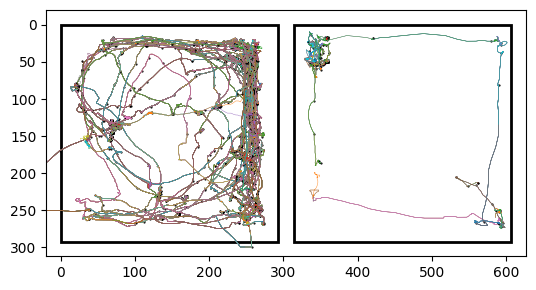

In [121]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.add_patch(
    patches.Rectangle(
        (l_coords_world["x"], l_coords_world["y"]),
        l_coords_world["w"],
        l_coords_world["h"],
        linewidth=2,
        edgecolor="k",
        facecolor="none",
    )
)
ax.add_patch(
    patches.Rectangle(
        (r_coords_world["x"], r_coords_world["y"]),
        r_coords_world["w"],
        r_coords_world["h"],
        linewidth=2,
        edgecolor="k",
        facecolor="none",
    )
)
ax.invert_yaxis()
ax.set_xlim([-20, 627])
ax.set_ylim([312, -20])
ax.set_aspect("equal", adjustable="box")
for i_song, s in enumerate(non_song_detections):
    t_non_song_start = s[0]
    t_non_song_stop = s[1]
    non_song_origin = s[2]
    s_song_start = int((t_non_song_start - t_before) * fps)
    s_song_stop = int((t_non_song_start + t_after) * fps)
    if s_song_start < 0 or s_song_stop > l_spineM_world.shape[0]:
        print(f"song {i_song} does not have enough margin")
        continue
    if non_song_origin == 0:
        ax.plot(
            l_spineM_world[s_song_start:s_song_stop, 0],
            l_spineM_world[s_song_start:s_song_stop, 1],
            linewidth=0.3,
        )
        song_start_loc = l_spineM_world[int(t_non_song_start * fps), :]
        ax.scatter(song_start_loc[0], song_start_loc[1], color="k", s=0.3, zorder=2)
    else:
        ax.plot(
            r_spineM_world[s_song_start:s_song_stop, 0],
            r_spineM_world[s_song_start:s_song_stop, 1],
            linewidth=0.3,
        )
        song_start_loc = r_spineM_world[int(t_non_song_start * fps), :]
        ax.scatter(song_start_loc[0], song_start_loc[1], color="k", s=0.3, zorder=2)
plt.tight_layout()
if SAVE_FIG:
    filename = f"{VIDEO_ID}__position_non_song.{SAVE_FIG_FORMAT}"
    file = os.path.join(SAVE_FIG_DIR, filename)
    plt.savefig(file, format=SAVE_FIG_FORMAT)
plt.show()

In [122]:
l_spineM_velocity = scipy.signal.savgol_filter(l_spineM_world, 25, 3, deriv=1, axis=0)
l_spineM_speed = np.linalg.norm(l_spineM_velocity, axis=1)
r_spineM_velocity = scipy.signal.savgol_filter(r_spineM_world, 25, 3, deriv=1, axis=0)
r_spineM_speed = np.linalg.norm(r_spineM_velocity, axis=1)

## plot speed around non-song

In [123]:
t_before = 7.5
t_after = 12.5

In [124]:
l_speed_non_songs = []
r_speed_non_songs = []
l_non_song_durations = []
r_non_song_durations = []
for i_song, s in enumerate(non_song_detections):
    t_non_song_start = s[0]
    t_non_song_stop = s[1]
    non_song_duration = t_non_song_stop - t_non_song_start
    non_song_origin = s[2]
    s_song_start = int((t_non_song_start - t_before) * fps)
    s_song_stop = int((t_non_song_start + t_after) * fps)
    if s_song_start < 0 or s_song_stop > l_spineM_world.shape[0]:
        print(f"song {i_song} does not have enough margin")
        continue
    if non_song_origin == 0:
        speed_song = l_spineM_speed[s_song_start:s_song_stop]
        l_speed_non_songs.append(speed_song)
        l_non_song_durations.append(non_song_duration)
    else:
        speed_song = r_spineM_speed[s_song_start:s_song_stop]
        r_speed_non_songs.append(speed_song)
        r_non_song_durations.append(non_song_duration)

l_speed_non_songs = np.array(l_speed_non_songs)
r_speed_non_songs = np.array(r_speed_non_songs)

In [125]:
# sort by duration
l_plot_order = np.argsort(l_non_song_durations)
l_non_song_durations = np.sort(l_non_song_durations)
l_speed_non_songs = l_speed_non_songs[l_plot_order]
r_plot_order = np.argsort(r_non_song_durations)
r_non_song_durations = np.sort(r_non_song_durations)
r_speed_non_songs = r_speed_non_songs[r_plot_order]

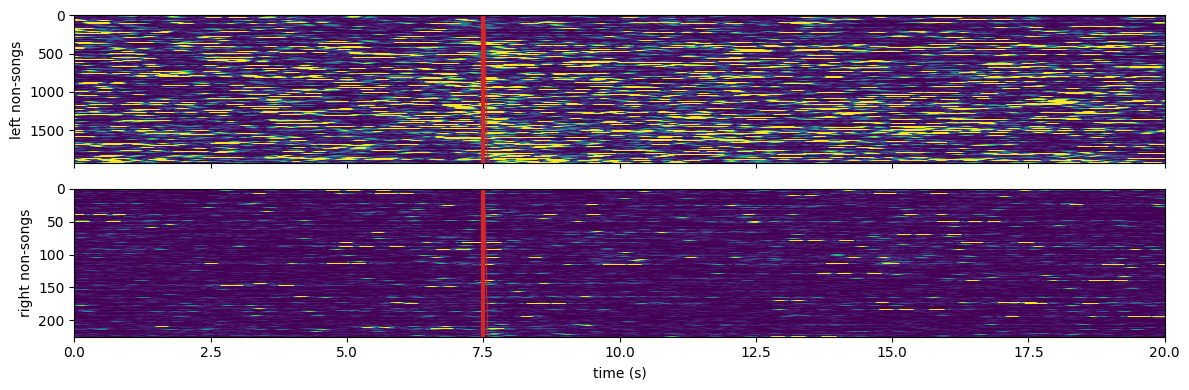

In [126]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=2, sharex=True)
if l_speed_non_songs.size != 0:
    axes[0].imshow(
        l_speed_non_songs,
        interpolation="none",
        extent=(0, l_speed_non_songs.shape[1] / fps, l_speed_non_songs.shape[0], 0),
        vmin=0,
        vmax=1.8,
    )
axes[0].axis("auto")
for i_row, non_song_duration in enumerate(l_non_song_durations):
    axes[0].vlines(x=t_before, ymin=i_row, ymax=i_row + 1, color="tab:red", linewidth=3)
    axes[0].vlines(
        x=t_before + non_song_duration,
        ymin=i_row,
        ymax=i_row + 1,
        color="tab:red",
        linewidth=1,
    )
if r_speed_non_songs.size != 0:
    axes[1].imshow(
        r_speed_non_songs,
        interpolation="none",
        extent=(0, r_speed_non_songs.shape[1] / fps, r_speed_non_songs.shape[0], 0),
        vmin=0,
        vmax=1.8,
    )
axes[1].axis("auto")
for i_row, non_song_duration in enumerate(r_non_song_durations):
    axes[1].vlines(x=t_before, ymin=i_row, ymax=i_row + 1, color="tab:red", linewidth=3)
    axes[1].vlines(
        x=t_before + non_song_duration,
        ymin=i_row,
        ymax=i_row + 1,
        color="tab:red",
        linewidth=1,
    )
axes[1].set_xlabel("time (s)")
axes[0].set_ylabel("left non-songs")
axes[1].set_ylabel("right non-songs")
plt.tight_layout()
if SAVE_FIG:
    filename = f"{VIDEO_ID}__speed_around_non_song.{SAVE_FIG_FORMAT}"
    file = os.path.join(SAVE_FIG_DIR, filename)
    plt.savefig(file, format=SAVE_FIG_FORMAT)
plt.show()